# <font color = lightcoral>Step 2: Visualizations - Temporal

## <font color = grey> Admin

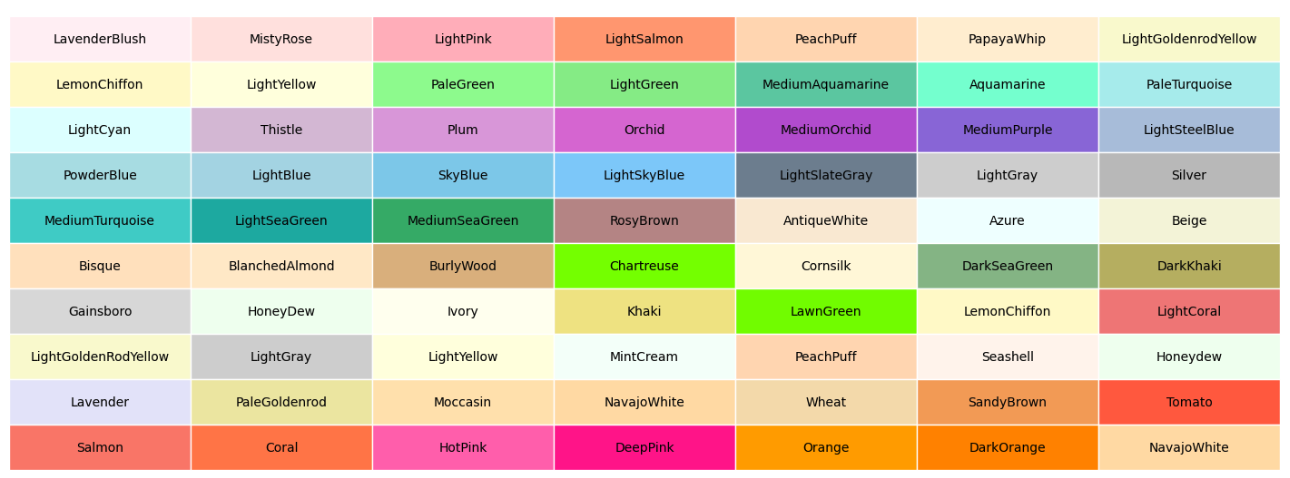

In [2]:
import pandas as pd
import os
import gzip
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
# Set display option to show the full length of the column
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# Determine the base directory based on the effective user ID
if os.geteuid() == 0:  # root user
    base_dir = '/root'
else:
    base_dir = '/home/sagemaker-user'

# Set the environment variable
os.environ['BASE_DIR'] = base_dir

# Verify the base directory
print(f"Base directory set to: {base_dir}")

Base directory set to: /root


___
# <font color = darkkhaki> Prepare working dataframe

In [4]:
import os
import gzip
import pandas as pd
import time

# Start timing
start_time = time.time()

# Define the file path
file_path = os.path.join(base_dir, '11.Data/01.BGL/01.Raw_CFDR/bgl2.gz')

# Function to process each chunk and extract relevant statistics
def process_chunk_full(chunk):
    # Split the lines into columns based on the structure of the data
    data = [line.split(' ', maxsplit=9) for line in chunk]

    # Add a new column for the alert status
    alert_status = ['Alert' if parts[0] != '-' else 'Normal' for parts in data]

    # Remove the first element (alert status) from each row in the data
    data = [parts[1:] for parts in data]

    # Define column names based on the observed structure
    columns = ['ID', 'Date', 'Seq_ID_1', 'Timestamp', 'Seq_ID_2', 'Category', 'Component', 'Message_Type', 'Message_Body']

    # Create a DataFrame
    df = pd.DataFrame(data, columns=columns)
    
    # Add the alert status column
    df.insert(0, 'AlertStatus', alert_status)

    return df

# Read the file in chunks and concatenate into a single DataFrame
chunk_size = 100000  # Adjust the chunk size as needed
df_list = []

with gzip.open(file_path, 'rt') as f:
    while True:
        chunk = []
        for _ in range(chunk_size):
            try:
                chunk.append(next(f).strip())
            except StopIteration:
                break
        if not chunk:
            break
        df_chunk = process_chunk_full(chunk)
        df_list.append(df_chunk)

# Concatenate all chunks into a single DataFrame
df_full = pd.concat(df_list, ignore_index=True)

# Display the DataFrame
# print(df_full)

# To verify, you can display summary statistics or perform any analysis as needed
print("Total records in the DataFrame:", len(df_full))

# Display the first 10 rows of the DataFrame
display(df_full.head(10))

# End timing
end_time = time.time()
duration = end_time - start_time
print(f"\nTime taken: {duration:.2f} seconds")
# df_full.head(10)

Total records in the DataFrame: 4747963


,AlertStatus,ID,Date,Seq_ID_1,Timestamp,Seq_ID_2,Category,Component,Message_Type,Message_Body
0,Normal,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.363779,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
1,Normal,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.527847,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
2,Normal,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.675872,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
3,Normal,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.823719,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
4,Normal,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.982731,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
5,Normal,1117838571,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.51.131467,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
6,Normal,1117838571,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.51.293532,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
7,Normal,1117838571,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.51.428563,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
8,Normal,1117838571,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.51.601412,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
9,Normal,1117838571,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.51.749199,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected



Time taken: 30.14 seconds


___
# <font color = darkkhaki> Temporal Analysis

## <font color = tomato> Alerts Only

#### <font color = darkseagreen> Normal Scale

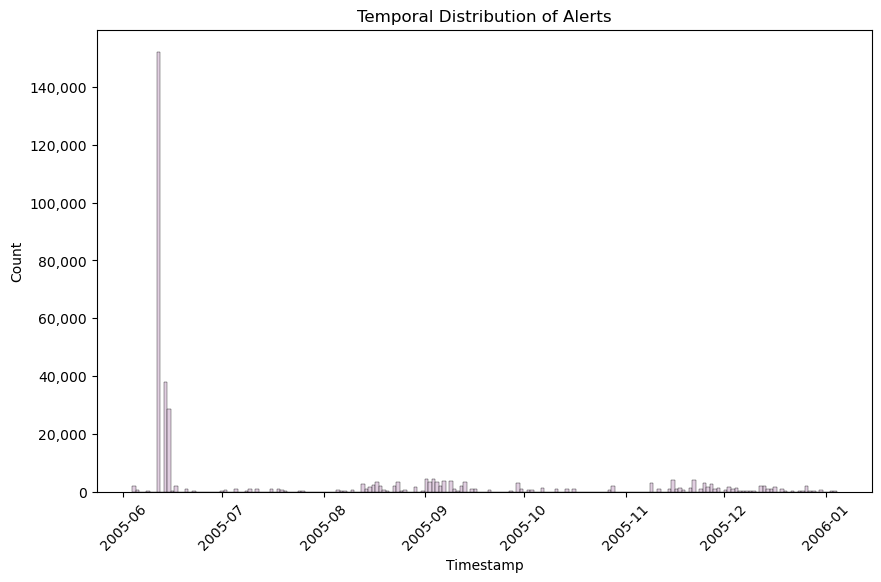


Time taken: 15.71 seconds


In [5]:
# # Start timing
start_time = time.time()

# Function to format y-axis with commas
def y_format(value, tick_number):
    return f'{int(value):,}'

# Convert the Timestamp column to datetime
df_full['Timestamp'] = pd.to_datetime(df_full['Timestamp'], format='%Y-%m-%d-%H.%M.%S.%f')

# Visualization 5: Temporal Distribution of Alerts
plt.figure(figsize=(10, 6))
sns.histplot(data=df_full[df_full['AlertStatus'] == 'Alert'], x='Timestamp', bins=200, color='thistle')
plt.title('Temporal Distribution of Alerts')
plt.xlabel('Timestamp')
plt.ylabel('Count')

# Format the y-axis numbers with commas
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_format))
plt.xticks(rotation=45)
plt.show()

end_time = time.time()
duration = end_time - start_time
print(f"\nTime taken: {duration:.2f} seconds")

#### <font color = darkseagreen> Log Scale

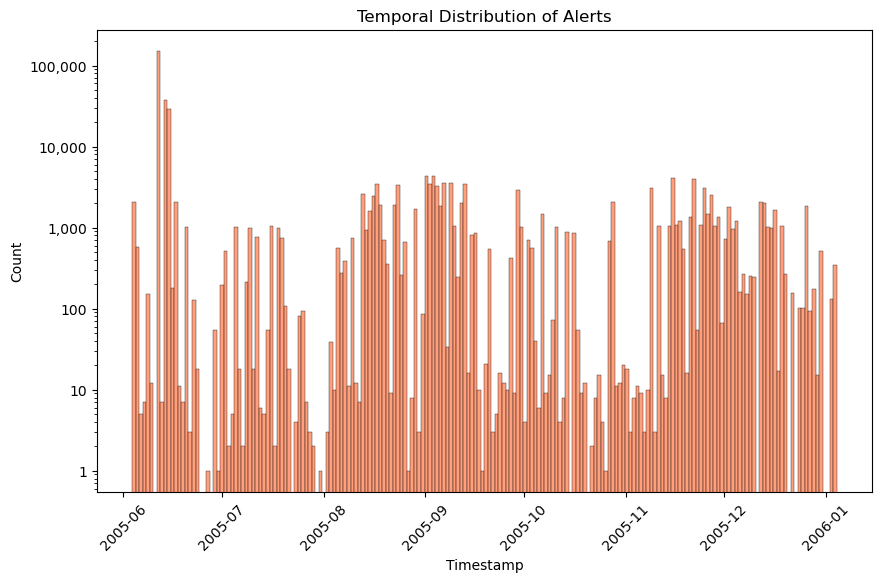


Time taken: 1.24 seconds


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Function to format y-axis with commas
def y_format(value, tick_number):
    return f'{int(value):,}'

# Start timing
start_time = time.time()

# Convert the Timestamp column to datetime
df_full['Timestamp'] = pd.to_datetime(df_full['Timestamp'], format='%Y-%m-%d-%H.%M.%S.%f')

# Visualization 5: Temporal Distribution of Alerts with Logarithmic Scale
plt.figure(figsize=(10, 6))
sns.histplot(data=df_full[df_full['AlertStatus'] == 'Alert'], x='Timestamp', bins=200, color='coral')
plt.title('Temporal Distribution of Alerts')
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.yscale('log')  # Apply logarithmic scale to the y-axis

# Format the y-axis numbers with commas
def y_format(value, tick_number):
    return f'{int(value):,}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(y_format))
plt.xticks(rotation=45)
plt.show()

# End timing
end_time = time.time()
duration = end_time - start_time
print(f"\nTime taken: {duration:.2f} seconds")


#### <font color = darkseagreen> Normal Scale with filter & dynamic binning (calculate num_days) --> Fixed X-Ticks

Minimum date: 2005-06-03 15:42:50.363779
Maximum date: 2006-01-04 08:00:05.233639
Number of days: 214


/tmp/ipykernel_20/1428795436.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alerts['Timestamp_bin'] = alerts['Timestamp'].dt.floor('D')


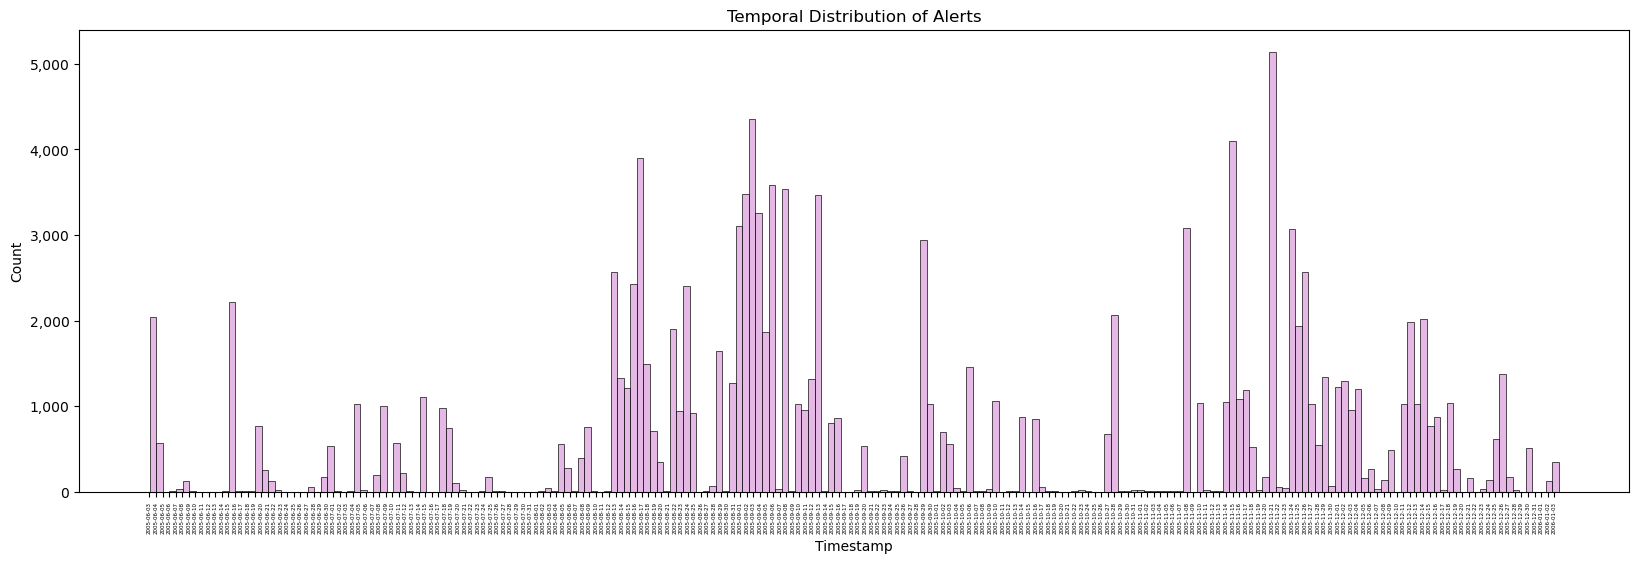


Time taken: 1.85 seconds


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Start timing
start_time = time.time()

# Convert the Timestamp column to datetime
df_full['Timestamp'] = pd.to_datetime(df_full['Timestamp'], format='%Y-%m-%d-%H.%M.%S.%f')

# Calculate the minimum and maximum dates
min_date = df_full['Timestamp'].min()
max_date = df_full['Timestamp'].max()

# Calculate the number of days between the min and max dates
num_days = (max_date - min_date).days

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")
print(f"Number of days: {num_days}")

# Calculate the counts per day (floor by day)
alerts = df_full[df_full['AlertStatus'] == 'Alert']
alerts['Timestamp_bin'] = alerts['Timestamp'].dt.floor('D')
alert_counts = alerts.groupby('Timestamp_bin').size().reset_index(name='Count')

# Filter out counts greater than 10,000
filtered_alert_counts = alert_counts[alert_counts['Count'] <= 10000]

# Visualization: Temporal Distribution of Alerts with Exclusion Criteria
plt.figure(figsize=(20, 6))
sns.histplot(data=alerts[alerts['Timestamp_bin'].isin(filtered_alert_counts['Timestamp_bin'])], 
             x='Timestamp', bins=num_days, color='plum')
plt.title('Temporal Distribution of Alerts')
plt.xlabel('Timestamp')
plt.ylabel('Count')

# Format the y-axis numbers with commas
def y_format(value, tick_number):
    return f'{int(value):,}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(y_format))

# Set x-axis labels to be vertical, in smaller font, and in the format yyyy-mm-dd
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(num_days))  # Ensure one tick per day
tick_labels = [min_date + pd.Timedelta(days=i) for i in range(num_days + 1)]
plt.gca().set_xticks(tick_labels)
plt.gca().set_xticklabels([date.strftime('%Y-%m-%d') for date in tick_labels], rotation=90, fontsize=4)
plt.show()

# End timing
end_time = time.time()
duration = end_time - start_time
print(f"\nTime taken: {duration:.2f} seconds")


In [8]:
filtered_alert_counts = alert_counts[alert_counts['Count'] <= 10000]

# Display the DataFrame with the counts per day
print("Filtered Alert Counts:")
display(filtered_alert_counts.head(10))

Filtered Alert Counts:


,Timestamp_bin,Count
0,2005-06-03,2
1,2005-06-04,2041
2,2005-06-05,571
3,2005-06-06,5
4,2005-06-07,7
5,2005-06-08,151
6,2005-06-09,10
7,2005-06-10,2
9,2005-06-12,3
12,2005-06-15,182


___
## <font color = tomato> Normal Messages Only

### <font color = peachpuff> Basic

Minimum date: 2005-06-03 15:42:50.363779
Maximum date: 2006-01-04 08:00:05.233639
Number of days: 214


/tmp/ipykernel_20/4104266379.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alerts['Timestamp_bin'] = alerts['Timestamp'].dt.floor('D')


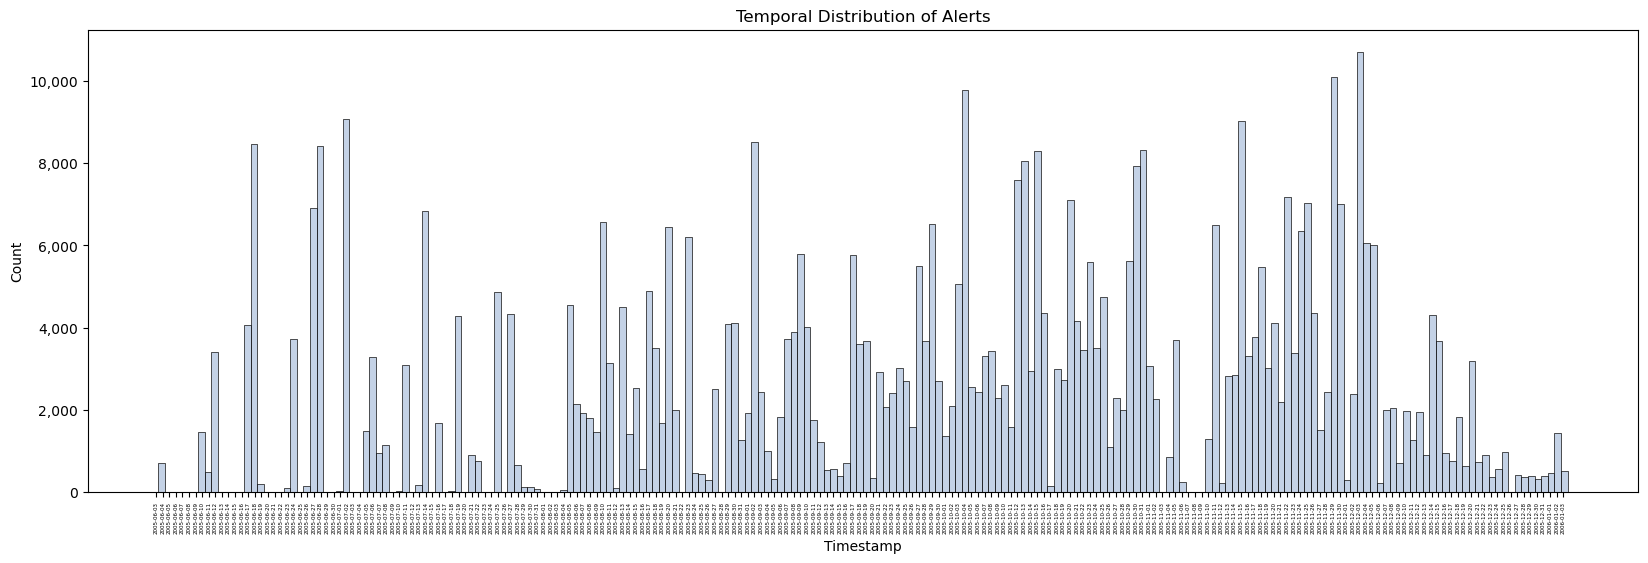


Time taken: 3.55 seconds


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Start timing
start_time = time.time()

# Convert the Timestamp column to datetime
df_full['Timestamp'] = pd.to_datetime(df_full['Timestamp'], format='%Y-%m-%d-%H.%M.%S.%f')

# Calculate the minimum and maximum dates
min_date = df_full['Timestamp'].min()
max_date = df_full['Timestamp'].max()

# Calculate the number of days between the min and max dates
num_days = (max_date - min_date).days

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")
print(f"Number of days: {num_days}")

# Calculate the counts per day (floor by day)
alerts = df_full[df_full['AlertStatus'] != 'Alert']
alerts['Timestamp_bin'] = alerts['Timestamp'].dt.floor('D')
alert_counts = alerts.groupby('Timestamp_bin').size().reset_index(name='Count')

# Filter out counts greater than 10,000
filtered_alert_counts = alert_counts[alert_counts['Count'] <= 10000]

# Visualization: Temporal Distribution of Alerts with Exclusion Criteria
plt.figure(figsize=(20, 6))
sns.histplot(data=alerts[alerts['Timestamp_bin'].isin(filtered_alert_counts['Timestamp_bin'])], 
             x='Timestamp', bins=num_days, color='lightsteelblue')
plt.title('Temporal Distribution of Alerts')
plt.xlabel('Timestamp')
plt.ylabel('Count')

# Format the y-axis numbers with commas
def y_format(value, tick_number):
    return f'{int(value):,}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(y_format))

# Set x-axis labels to be vertical, in smaller font, and in the format yyyy-mm-dd
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(num_days))  # Ensure one tick per day
tick_labels = [min_date + pd.Timedelta(days=i) for i in range(num_days + 1)]
plt.gca().set_xticks(tick_labels)
plt.gca().set_xticklabels([date.strftime('%Y-%m-%d') for date in tick_labels], rotation=90, fontsize=4)
plt.show()

# End timing
end_time = time.time()
duration = end_time - start_time
print(f"\nTime taken: {duration:.2f} seconds")


In [10]:
filtered_alert_counts = alert_counts[alert_counts['Count'] <= 10000]

# Display the DataFrame with the counts per day
print("Filtered Alert Counts:")
display(filtered_alert_counts.head(10))

Filtered Alert Counts:


,Timestamp_bin,Count
1,2005-06-04,692
7,2005-06-10,1460
8,2005-06-11,484
9,2005-06-12,3417
14,2005-06-17,4064
15,2005-06-18,5295
16,2005-06-19,3353
21,2005-06-24,3817
24,2005-06-27,7050
25,2005-06-28,8430


___
## <font color = tomato> Normal & Alerts in context

### <font color = peachpuff> Normal Scale

Minimum date: 2005-06-03 15:42:50.363779
Maximum date: 2006-01-04 08:00:05.233639
Number of days: 214


/tmp/ipykernel_20/1724833990.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alerts['Timestamp_bin'] = alerts['Timestamp'].dt.floor('D')
/tmp/ipykernel_20/1724833990.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normals['Timestamp_bin'] = normals['Timestamp'].dt.floor('D')


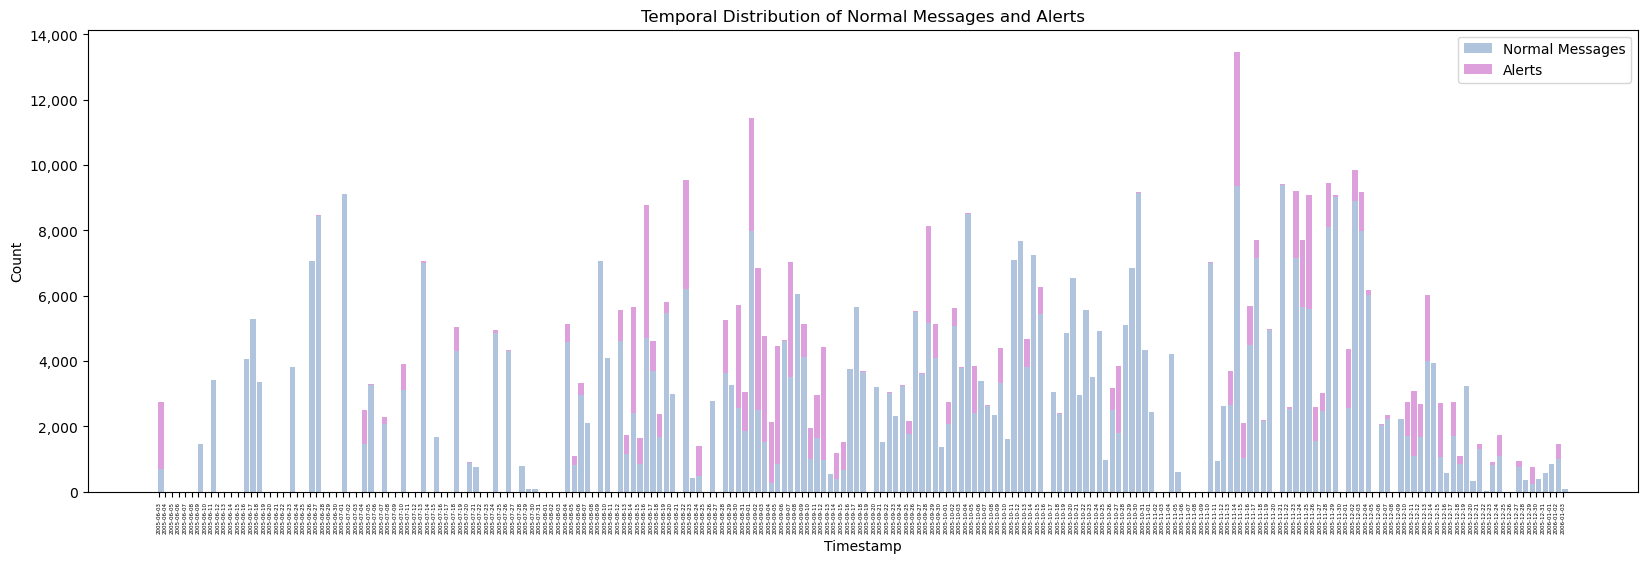


Time taken: 4.14 seconds


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Start timing
start_time = time.time()

# Convert the Timestamp column to datetime
df_full['Timestamp'] = pd.to_datetime(df_full['Timestamp'], format='%Y-%m-%d-%H.%M.%S.%f')

# Calculate the minimum and maximum dates
min_date = df_full['Timestamp'].min()
max_date = df_full['Timestamp'].max()

# Calculate the number of days between the min and max dates
num_days = (max_date - min_date).days

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")
print(f"Number of days: {num_days}")

# Calculate the counts per day for alerts and normal messages
alerts = df_full[df_full['AlertStatus'] == 'Alert']
normals = df_full[df_full['AlertStatus'] != 'Alert']

alerts['Timestamp_bin'] = alerts['Timestamp'].dt.floor('D')
normals['Timestamp_bin'] = normals['Timestamp'].dt.floor('D')

alert_counts = alerts.groupby('Timestamp_bin').size().reset_index(name='Count')
normal_counts = normals.groupby('Timestamp_bin').size().reset_index(name='Count')

# Merge alert counts and normal counts into a single DataFrame
merged_counts = pd.merge(normal_counts, alert_counts, on='Timestamp_bin', how='outer', suffixes=('_normal', '_alert')).fillna(0)

# Filter out counts greater than 10,000
filtered_counts = merged_counts[(merged_counts['Count_normal'] <= 10000) & (merged_counts['Count_alert'] <= 10000)]

# Visualization: Temporal Distribution of Normal Messages and Alerts with Exclusion Criteria
plt.figure(figsize=(20, 6))

plt.bar(filtered_counts['Timestamp_bin'], filtered_counts['Count_normal'], color='lightsteelblue', label='Normal Messages')
plt.bar(filtered_counts['Timestamp_bin'], filtered_counts['Count_alert'], bottom=filtered_counts['Count_normal'], color='plum', label='Alerts')

plt.title('Temporal Distribution of Normal Messages and Alerts')
plt.xlabel('Timestamp')
plt.ylabel('Count')

# Format the y-axis numbers with commas
def y_format(value, tick_number):
    return f'{int(value):,}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(y_format))

# Set x-axis labels to be vertical, in smaller font, and in the format yyyy-mm-dd
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(num_days))  # Ensure one tick per day
tick_labels = [min_date + pd.Timedelta(days=i) for i in range(num_days + 1)]
plt.gca().set_xticks(tick_labels)
plt.gca().set_xticklabels([date.strftime('%Y-%m-%d') for date in tick_labels], rotation=90, fontsize=4)

plt.legend()
plt.show()

# End timing
end_time = time.time()
duration = end_time - start_time
print(f"\nTime taken: {duration:.2f} seconds")


### <font color = peachpuff> Log Scale

Minimum date: 2005-06-03 15:42:50.363779
Maximum date: 2006-01-04 08:00:05.233639
Number of days: 214


/tmp/ipykernel_20/740722415.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alerts['Timestamp_bin'] = alerts['Timestamp'].dt.floor('D')
/tmp/ipykernel_20/740722415.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normals['Timestamp_bin'] = normals['Timestamp'].dt.floor('D')


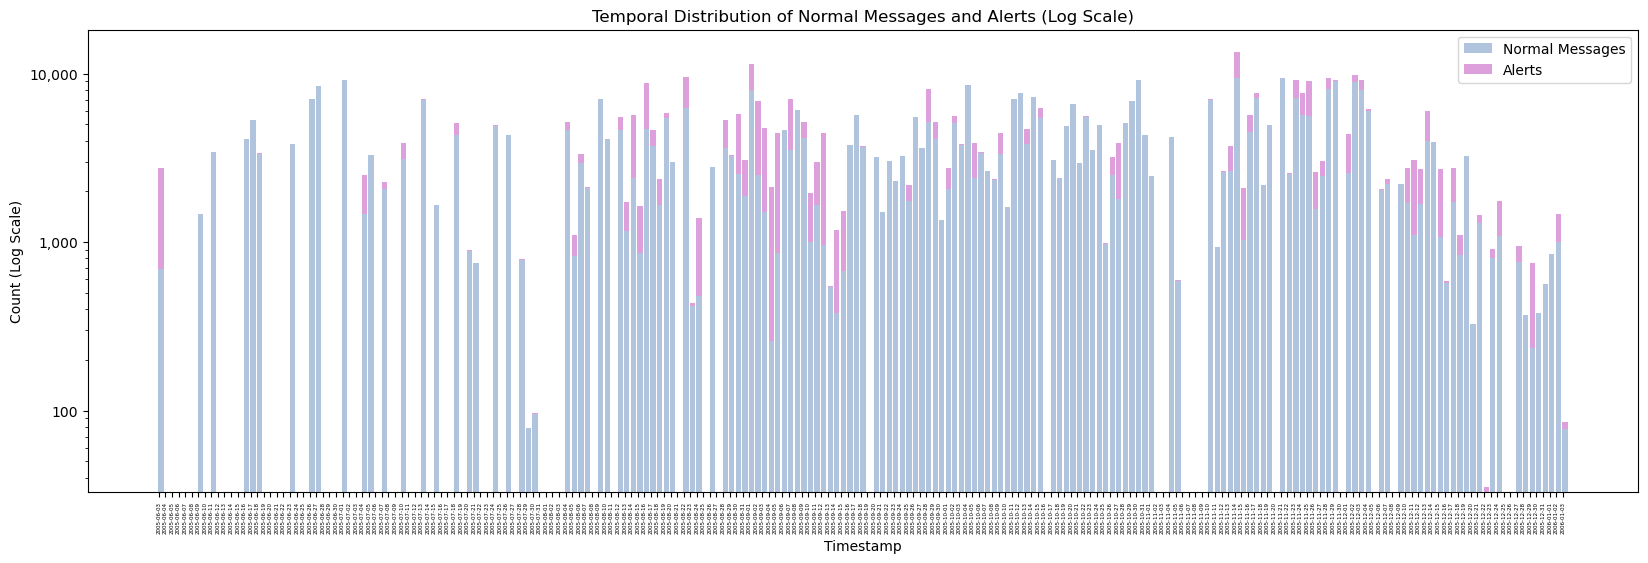


Time taken: 4.69 seconds


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter, LogLocator

# Start timing
start_time = time.time()

# Convert the Timestamp column to datetime
df_full['Timestamp'] = pd.to_datetime(df_full['Timestamp'], format='%Y-%m-%d-%H.%M.%S.%f')

# Calculate the minimum and maximum dates
min_date = df_full['Timestamp'].min()
max_date = df_full['Timestamp'].max()

# Calculate the number of days between the min and max dates
num_days = (max_date - min_date).days

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")
print(f"Number of days: {num_days}")

# Calculate the counts per day for alerts and normal messages
alerts = df_full[df_full['AlertStatus'] == 'Alert']
normals = df_full[df_full['AlertStatus'] != 'Alert']

alerts['Timestamp_bin'] = alerts['Timestamp'].dt.floor('D')
normals['Timestamp_bin'] = normals['Timestamp'].dt.floor('D')

alert_counts = alerts.groupby('Timestamp_bin').size().reset_index(name='Count')
normal_counts = normals.groupby('Timestamp_bin').size().reset_index(name='Count')

# Merge alert counts and normal counts into a single DataFrame
merged_counts = pd.merge(normal_counts, alert_counts, on='Timestamp_bin', how='outer', suffixes=('_normal', '_alert')).fillna(0)

# Filter out counts greater than 10,000
filtered_counts = merged_counts[(merged_counts['Count_normal'] <= 10000) & (merged_counts['Count_alert'] <= 10000)]

# Visualization: Temporal Distribution of Normal Messages and Alerts with Exclusion Criteria
plt.figure(figsize=(20, 6))

plt.bar(filtered_counts['Timestamp_bin'], filtered_counts['Count_normal'], color='lightsteelblue', label='Normal Messages')
plt.bar(filtered_counts['Timestamp_bin'], filtered_counts['Count_alert'], bottom=filtered_counts['Count_normal'], color='plum', label='Alerts')

plt.title('Temporal Distribution of Normal Messages and Alerts (Log Scale)')
plt.xlabel('Timestamp')
plt.ylabel('Count (Log Scale)')

# Set the y-axis to log scale
plt.yscale('log')

# Format the y-axis numbers with commas
def y_format(value, tick_number):
    return f'{int(value):,}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(y_format))

# Set x-axis labels to be vertical, in smaller font, and in the format yyyy-mm-dd
tick_labels = pd.date_range(start=min_date, end=max_date, freq='D')
plt.gca().set_xticks(tick_labels)
plt.gca().set_xticklabels(tick_labels.strftime('%Y-%m-%d'), rotation=90, fontsize=4)

plt.legend()
plt.show()

# End timing
end_time = time.time()
duration = end_time - start_time
print(f"\nTime taken: {duration:.2f} seconds")
